# Introduction:
#### - Mapping cross-sections with IDs
#### - Converting the proccessed cross-sections to parquets, geopackages, Iceberg tables by HUC 
#### - Querying for cross-sections By IDs 

## Modules

In [ ]:
import collections
import os
import pickle
import warnings

import pandas as pd
import pyarrow.parquet as pq

from icefabric_manage import MapData

warnings.filterwarnings("ignore")

## Demo I:
### Mapping FIM-C Data to Model ID, HUC #, Reach ID, Network ID, etc

In [3]:
# Instantiate class
obj = MapData(data_dir=f'{os.getcwd()}/segment_data/',
              subfolder_key_prefix='ble')

# Extract list of fim-c data sample's directories.
fim_data_dirs = obj.fim_data_dirs

# Categorize FIM-C data sample files (e.g. geopackage of a given model @ HUC#, json, source_models.gpkg, ripple.gpkg)
model_gpkg_dirs, src_models_gpkg_dirs, rip_gpkg_dirs = (
    obj.model_gpkg_dirs,
    obj.src_models_gpkg_dirs,
    obj.rip_gpkg_dirs,
)
gpkg_dirs, json_dirs = obj.gpkg_dirs, obj.json_dirs

model_gpkg_tablenames, src_models_gpkg_tablenames, rip_gpkg_tablenames = (
    obj.model_gpkg_tablenames,
    obj.src_models_gpkg_tablenames,
    obj.rip_gpkg_tablenames,
)
gpkg_tablenames, json_tablenames = obj.gpkg_tablenames, obj.json_tablenames

# Generate a dictionary to map each conflation json files to their corresponding model_id & HUC #.
model2huc_map = obj.id2json

# Generated maps of model_id & HUC # to xs (for both us & ds cross-section) to reach ID & "network_to_id"
us_xs2id_map = obj.us_ref_dict
ds_xs2id_map = obj.ds_ref_dict

# Generated map of model_id & HUC # to each HEC-RAS model's geopackage.
model_id2gpkg_map = obj.model_id2gpkg

# Generated map of HUC # to each ripple geopackage.
rip_huc2gpkg_map = obj.rip_huc2gpkg

# Map IDs to each model's cross-section instance
id2xs_dfs = obj.xs_df_list

# [OPTIONAL: If a user wants to extract individual river geopandas, parquet, &/or gpkg]
# Map of XS as geopandas per river per HUC w/ their inherited CRS by HUC
# xsbyriver_map = obj.groupbyriver_dict

# [OPTIONAL: Map of inherited CRS to HUC, model_id, river name]
crs_map = obj.crs_dict

# Conslidate all HEC-RAS models' cross-sections featuring their corresponding IDs.
consolidated_id2xs = obj.consolidated_id2xs

The model_id @ HUC# (('SHR6_1', '09020301')) IS NOT featured in current model @ HUC's conflation json file.
The model_id @ HUC# (('SandHillRiver7', '09020301')) IS NOT featured in current model @ HUC's conflation json file.
The model_id @ HUC# (('SandHillRiver7_1', '09020301')) IS NOT featured in current model @ HUC's conflation json file.
The model_id @ HUC# (('SHR6', '09020301')) IS NOT featured in current model @ HUC's conflation json file.
The model_id @ HUC# (('Kelly_Creek_T1', '06040002')) IS NOT featured in current model @ HUC's conflation json file.
The model_id @ HUC# (('Duck_River_Trib4', '06040002')) IS NOT featured in current model @ HUC's conflation json file.
The model_id @ HUC# (('Bell_Buckle_CrT1', '06040002')) IS NOT featured in current model @ HUC's conflation json file.
The model_id @ HUC# (('Trib_to_Holland', '06040002')) IS NOT featured in current model @ HUC's conflation json file.
The model_id @ HUC# (('Stream0510', '01020002')) IS NOT featured in current model @

In [4]:
consolidated_id2xs.head(5)
# consolidated_id2xs.shape

,river,reach,river_reach,river_station,river_reach_rs,thalweg,xs_max_elevation,left_reach_length,right_reach_length,channel_reach_length,...,number_of_coords,flows,profile_names,geometry,huc,model_id,us_reach_id,us_network_to_id,ds_reach_id,ds_network_to_id
0,BapCr,Reach1,"BapCr ,Reach1",48077.80,BapCr Reach1 48077.8,743.50,756.11,207.08,207.08,207.08,...,3,607.0\n798.0\n943.0\n1100.0\n1460.0\n1650.0,10%\n4%\n2%\n1%\n0.2%\n1%+,"LINESTRING (436369.214 1962609.838, 436369.691...",07130010,sa_1,13801626,13801634,None,None
1,BapCr,Reach1,"BapCr ,Reach1",47870.72,BapCr Reach1 47870.72,742.54,755.74,259.78,259.78,259.78,...,2,607.0\n798.0\n943.0\n1100.0\n1460.0\n1650.0,10%\n4%\n2%\n1%\n0.2%\n1%+,"LINESTRING (436352.44 1962575.103, 436311.185 ...",07130010,sa_1,None,None,None,None
2,BapCr,Reach1,"BapCr ,Reach1",47610.94,BapCr Reach1 47610.94,741.94,755.17,374.57,374.57,374.57,...,2,607.0\n798.0\n943.0\n1100.0\n1460.0\n1650.0,10%\n4%\n2%\n1%\n0.2%\n1%+,"LINESTRING (436323.593 1962531.597, 436264.538...",07130010,sa_1,None,None,None,None
3,BapCr,Reach1,"BapCr ,Reach1",47236.37,BapCr Reach1 47236.37,740.62,754.18,333.59,333.59,333.59,...,2,607.0\n798.0\n943.0\n1100.0\n1460.0\n1650.0,10%\n4%\n2%\n1%\n0.2%\n1%+,"LINESTRING (436310.242 1962416.052, 436236.357...",07130010,sa_1,None,None,None,None
4,BapCr,Reach1,"BapCr ,Reach1",46902.78,BapCr Reach1 46902.78,739.04,757.19,375.07,375.07,375.07,...,2,607.0\n798.0\n943.0\n1100.0\n1460.0\n1650.0,10%\n4%\n2%\n1%\n0.2%\n1%+,"LINESTRING (436292.364 1962322.688, 436219.117...",07130010,sa_1,None,None,None,None


## Demo I Result:
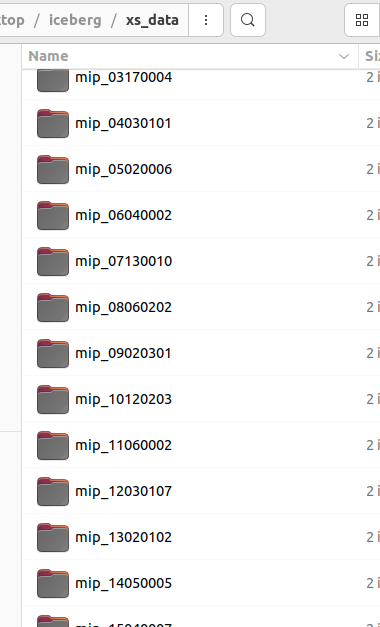


## Demo II: 
### Querying XS Instance by Network ID

In [5]:
# Scenario I
us_network_to_id = "11908200"
queried_xsbyid = consolidated_id2xs[consolidated_id2xs["us_network_to_id"] == us_network_to_id]
queried_xsbyid

,river,reach,river_reach,river_station,river_reach_rs,thalweg,xs_max_elevation,left_reach_length,right_reach_length,channel_reach_length,...,number_of_coords,flows,profile_names,geometry,huc,model_id,us_reach_id,us_network_to_id,ds_reach_id,ds_network_to_id
28507,BattleCrCypress,1,"BattleCrCypress ,1",13227.35,BattleCrCypress 1 13227.35,17.88,82.69,464.51,459.84,462.47,...,2,1230.0\n1330.0,1%\n1% Ultimate,"LINESTRING (1665550.543 1889977.407, 1664479.0...",02060006,BattleCreekCypressSwamp,11908190,11908200,None,None


In [6]:
# Scenario II
us_network_to_id = "13801634"
queried_xsbyid = consolidated_id2xs[consolidated_id2xs["us_network_to_id"] == us_network_to_id]
queried_xsbyid

,river,reach,river_reach,river_station,river_reach_rs,thalweg,xs_max_elevation,left_reach_length,right_reach_length,channel_reach_length,...,number_of_coords,flows,profile_names,geometry,huc,model_id,us_reach_id,us_network_to_id,ds_reach_id,ds_network_to_id
0,BapCr,Reach1,"BapCr ,Reach1",48077.8,BapCr Reach1 48077.8,743.5,756.11,207.08,207.08,207.08,...,3,607.0\n798.0\n943.0\n1100.0\n1460.0\n1650.0,10%\n4%\n2%\n1%\n0.2%\n1%+,"LINESTRING (436369.214 1962609.838, 436369.691...",07130010,sa_1,13801626,13801634,None,None


In [7]:
# Scenario III
us_network_to_id = "21294311"
queried_xsbyid = consolidated_id2xs[consolidated_id2xs["us_network_to_id"] == us_network_to_id]
queried_xsbyid

,river,reach,river_reach,river_station,river_reach_rs,thalweg,xs_max_elevation,left_reach_length,right_reach_length,channel_reach_length,...,number_of_coords,flows,profile_names,geometry,huc,model_id,us_reach_id,us_network_to_id,ds_reach_id,ds_network_to_id
30796,1242,15,"1242,15",789.6214,1242 15 789.6214,3520.558,3568.420,85.14416,93.27657,93.45487,...,10,193.0\n359.0\n522.0\n723.0\n919.0\n569.0\n1347.0,10yr\n25yr\n50yr\n100yr\n100plus\n100minus\n5...,"LINESTRING (-1355141.15 1253454.057, -1355086....",15040007,1242_ras,21294309,21294311,None,None
30878,1195,109,"1195 ,109",6071.4750,1195 109 6071.475,3534.450,3616.780,206.69170,147.98750,195.85400,...,8,1746.0\n3146.0\n4514.0\n6152.0\n7819.0\n4840.0...,10yr\n25yr\n50yr\n100yr\n100plus\n100minus\n500yr,"LINESTRING (-1355056.984 1253633.24, -1355173....",15040007,1195_ras,21294309,21294311,21294243,21294309
30966,1236,61,"1236,61",725.2979,1236 61 725.2979,3533.829,3587.055,151.74160,139.83360,148.79750,...,7,433.0\n796.0\n1152.0\n1584.0\n2014.0\n1247.0\n...,10yr\n25yr\n50yr\n100yr\n100plus\n100minus\n5...,"LINESTRING (-1355130.287 1253615.579, -1355168...",15040007,1236_ras,21294309,21294311,21295551,21294309


In [8]:
# Scenario IV
us_network_to_id = "23597193"
queried_xsbyid = consolidated_id2xs[consolidated_id2xs["us_network_to_id"] == us_network_to_id]
queried_xsbyid

,river,reach,river_reach,river_station,river_reach_rs,thalweg,xs_max_elevation,left_reach_length,right_reach_length,channel_reach_length,...,number_of_coords,flows,profile_names,geometry,huc,model_id,us_reach_id,us_network_to_id,ds_reach_id,ds_network_to_id
19216,cottonwood_creek,45,"cottonwood_creek,45",1773.175,cottonwood_creek 45 1773.175,1342.295,1450.915,166.0375,330.7853,294.9549,...,14,7096.0\n9743.0\n4449.0,100yr\n100yrplus\n100yrminus,"LINESTRING (-1536837.566 2728068.167, -1536849...",17060305,cottonwood_creek_1_ras,23597195,23597193,23597197,23597195


## Demo III: 
### Querying Each XS Layer by Model ID & HUC Number

In [9]:
# Scenario I
model_id = "GF_EGF_FIS_Submittal1204"
huc_num = "09020301"

tt = model_id2gpkg_map[(model_id, huc_num)]["XS"]
tt.insert(0, "huc", tt.pop("huc"))
tt.insert(1, "model_id", tt.pop("model_id"))
tt.insert(2, "us_reach_id", tt.pop("us_reach_id"))
tt.insert(3, "us_network_to_id", tt.pop("us_network_to_id"))
tt.insert(4, "ds_reach_id", tt.pop("ds_reach_id"))
tt.insert(5, "ds_network_to_id", tt.pop("ds_network_to_id"))
tt.insert(6, "river_reach_rs", tt.pop("river_reach_rs"))
tt.insert(7, "thalweg", tt.pop("thalweg"))
tt.insert(8, "xs_max_elevation", tt.pop("xs_max_elevation"))
tt.insert(9, "river_station", tt.pop("river_station"))
tt.head(2)

,huc,model_id,us_reach_id,us_network_to_id,ds_reach_id,ds_network_to_id,river_reach_rs,thalweg,xs_max_elevation,river_station,...,right_reach_length,channel_reach_length,ras_data,station_elevation_points,bank_stations,number_of_station_elevation_points,number_of_coords,flows,profile_names,geometry
0,09020301,GF_EGF_FIS_Submittal1204,9398232,7066766,None,None,RRN GFEGF 170.0,774.37,834.80,170.0,...,700.0,934.0,"Type RM Length L Ch R = 1 ,170 ,900,934,70...","[(44883.4, 834.0), (47186.0, 832.44), (49148.8...","['50124', '50484']",238,7,49000.0\n71000.0\n89000.0\n139000.0,10-Year\n50-Year\n100-Year\n500 Year,"LINESTRING (2818284.13 354233.597, 2818770.518..."
1,09020301,GF_EGF_FIS_Submittal1204,None,None,None,None,RRN GFEGF 169.0,772.69,842.37,169.0,...,340.0,344.0,"Type RM Length L Ch R = 1 ,169 ,450,344,34...","[(45195.48, 833.55), (45220.07, 833.6), (45256...","['50192', '50563']",263,8,49000.0\n71000.0\n89000.0\n139000.0,10-Year\n50-Year\n100-Year\n500 Year,"LINESTRING (2815855.489 354032.803, 2816473.50..."


In [10]:
# Scenario II
model_id = "sa_1"
huc_num = "07130010"

tt = model_id2gpkg_map[(model_id, huc_num)]["XS"]
tt.insert(0, "huc", tt.pop("huc"))
tt.insert(1, "model_id", tt.pop("model_id"))
tt.insert(2, "us_reach_id", tt.pop("us_reach_id"))
tt.insert(3, "us_network_to_id", tt.pop("us_network_to_id"))
tt.insert(4, "ds_reach_id", tt.pop("ds_reach_id"))
tt.insert(5, "ds_network_to_id", tt.pop("ds_network_to_id"))
tt.insert(6, "river_reach_rs", tt.pop("river_reach_rs"))
tt.insert(7, "thalweg", tt.pop("thalweg"))
tt.insert(8, "xs_max_elevation", tt.pop("xs_max_elevation"))
tt.insert(9, "river_station", tt.pop("river_station"))
tt.head(2)

,huc,model_id,us_reach_id,us_network_to_id,ds_reach_id,ds_network_to_id,river_reach_rs,thalweg,xs_max_elevation,river_station,...,right_reach_length,channel_reach_length,ras_data,station_elevation_points,bank_stations,number_of_station_elevation_points,number_of_coords,flows,profile_names,geometry
0,07130010,sa_1,13801626,13801634,None,None,BapCr Reach1 48077.8,743.50,756.11,48077.80,...,207.08,207.08,"Type RM Length L Ch R = 1 ,48077.80,207.08,207...","[(0.0, 754.17), (3.42, 753.96), (6.85, 753.88)...","['99.27', '143.86']",67,3,607.0\n798.0\n943.0\n1100.0\n1460.0\n1650.0,10%\n4%\n2%\n1%\n0.2%\n1%+,"LINESTRING (2120750.469 1421598.418, 2120758.2..."
1,07130010,sa_1,None,None,None,None,BapCr Reach1 47870.72,742.54,755.74,47870.72,...,259.78,259.78,"Type RM Length L Ch R = 1 ,47870.72,259.78,259...","[(0.0, 755.74), (6.92, 755.26), (10.38, 755.11...","['65.75', '107.27']",58,2,607.0\n798.0\n943.0\n1100.0\n1460.0\n1650.0,10%\n4%\n2%\n1%\n0.2%\n1%+,"LINESTRING (2120687.969 1421489.043, 2120560.3..."


In [11]:
# Scenario III
model_id = "BorregoCyn_Existing"
huc_num = "18070204"

tt = model_id2gpkg_map[(model_id, huc_num)]["XS"]
tt.insert(0, "huc", tt.pop("huc"))
tt.insert(1, "model_id", tt.pop("model_id"))
tt.insert(2, "us_reach_id", tt.pop("us_reach_id"))
tt.insert(3, "us_network_to_id", tt.pop("us_network_to_id"))
tt.insert(4, "ds_reach_id", tt.pop("ds_reach_id"))
tt.insert(5, "ds_network_to_id", tt.pop("ds_network_to_id"))
tt.insert(6, "river_reach_rs", tt.pop("river_reach_rs"))
tt.insert(7, "thalweg", tt.pop("thalweg"))
tt.insert(8, "xs_max_elevation", tt.pop("xs_max_elevation"))
tt.insert(9, "river_station", tt.pop("river_station"))
tt.head(2)

,huc,model_id,us_reach_id,us_network_to_id,ds_reach_id,ds_network_to_id,river_reach_rs,thalweg,xs_max_elevation,river_station,...,right_reach_length,channel_reach_length,ras_data,station_elevation_points,bank_stations,number_of_station_elevation_points,number_of_coords,flows,profile_names,geometry
0,18070204,BorregoCyn_Existing,None,None,None,None,Borrego Cyn Reach 1 US 1345.913,681.12,697.36,1345.913,...,149.24,148.80,"Type RM Length L Ch R = 1 ,1345.913,155.13,148...","[(0.0, 692.38), (121.89, 691.88), (205.0, 692....","['205', '255']",23,2,1126.0,PF 1,"LINESTRING (6127868.943 2194456.933, 6127820.9..."
1,18070204,BorregoCyn_Existing,None,None,None,None,Borrego Cyn Reach 1 US 1197.11,680.18,697.56,1197.110,...,200.51,200.29,"Type RM Length L Ch R = 1 ,1197.11 ,203.67,200...","[(0.0, 692.64), (14.99, 692.64), (16.4, 692.64...","['164', '256']",37,2,1126.0,PF 1,"LINESTRING (6127720.709 2194447.582, 6127672.7..."


In [12]:
# Scenario IV
model_id = "cottonwood_creek_ras"
huc_num = "17060305"

tt = model_id2gpkg_map[(model_id, huc_num)]["XS"]
tt.insert(0, "huc", tt.pop("huc"))
tt.insert(1, "model_id", tt.pop("model_id"))
tt.insert(2, "us_reach_id", tt.pop("us_reach_id"))
tt.insert(3, "us_network_to_id", tt.pop("us_network_to_id"))
tt.insert(4, "ds_reach_id", tt.pop("ds_reach_id"))
tt.insert(5, "ds_network_to_id", tt.pop("ds_network_to_id"))
tt.insert(6, "river_reach_rs", tt.pop("river_reach_rs"))
tt.insert(7, "thalweg", tt.pop("thalweg"))
tt.insert(8, "xs_max_elevation", tt.pop("xs_max_elevation"))
tt.insert(9, "river_station", tt.pop("river_station"))
tt.head(2)
# tt.tail()

,huc,model_id,us_reach_id,us_network_to_id,ds_reach_id,ds_network_to_id,river_reach_rs,thalweg,xs_max_elevation,river_station,...,right_reach_length,channel_reach_length,ras_data,station_elevation_points,bank_stations,number_of_station_elevation_points,number_of_coords,flows,profile_names,geometry
0,17060305,cottonwood_creek_ras,23597283,23597281,None,None,cottonwood_creek 874 89457.28,3764.997,3862.724,89457.28,...,99.9421,99.9421,"Type RM Length L Ch R = 1 ,89457.28,99.942100,...","[(9649.015, 3806.544), (9649.124, 3806.528), (...","['9649.015', '10350.99']",86,8,92.0,PF 1,"LINESTRING (2462395.976 1602716.665, 2462389.5..."
1,17060305,cottonwood_creek_ras,None,None,None,None,cottonwood_creek 874 89357.33,3762.666,3867.248,89357.33,...,99.9421,99.9421,"Type RM Length L Ch R = 1 ,89357.33,99.942100,...","[(9649.021, 3808.923), (9652.402, 3808.42), (9...","['9649.021', '10350.98']",83,9,92.0,PF 1,"LINESTRING (2462481.133 1602698.905, 2462480.8..."


## Demo IVa: 
### Per HUC, save & verify each river's XS data as parquet & geopackage

In [13]:
# # # Scenario I
# # Read Parquet file
# df1 = pd.read_parquet('/home/sylvia.chin/Desktop/iceberg/xs_data/huc_07130010/BapCr.parquet',
#                       engine='pyarrow')

# # Display the first few rows
# print(df1.head())

In [14]:
# # # Scenario II

# # Read Parquet file
# df2 = pd.read_parquet('/home/sylvia.chin/Desktop/iceberg/xs_data/huc_01020002/Martin Stream.parquet',
#                       engine='pyarrow')

# # Display the first few rows
# print(df2.head())

## Demo IVb: 
### Per HUC, save & verify each HUC's XS data as parquet & geopackage 

In [15]:
# # Scenario I
# Read Parquet file
df1 = pd.read_parquet(f"/{os.getcwd()}/xs_data/mip_10120203/huc_10120203.parquet", engine="pyarrow")

# set(df1['river'])
# set(df1['huc'])
df1[["huc", "river", "model_id", "us_reach_id", "ds_reach_id"]]

,huc,river,model_id,us_reach_id,ds_reach_id
7042,10120203,Spearfish Creek,Spearfish_Cr_LOMR_FEMA_RESPONSE_1,None,None
7043,10120203,Spearfish Creek,Spearfish_Cr_LOMR_FEMA_RESPONSE_1,None,None
7044,10120203,Spearfish Creek,Spearfish_Cr_LOMR_FEMA_RESPONSE_1,None,None
7045,10120203,Spearfish Creek,Spearfish_Cr_LOMR_FEMA_RESPONSE_1,None,None
7046,10120203,Spearfish Creek,Spearfish_Cr_LOMR_FEMA_RESPONSE_1,None,None
...,...,...,...,...,...
7225,10120203,Spearfish Creek,Spearfish_Cr_LOMR_FEMA_RESPONSE,None,None
7226,10120203,Spearfish Creek,Spearfish_Cr_LOMR_FEMA_RESPONSE,None,None
7227,10120203,Spearfish Creek,Spearfish_Cr_LOMR_FEMA_RESPONSE,None,None
7228,10120203,Spearfish Creek,Spearfish_Cr_LOMR_FEMA_RESPONSE,None,None


#### Cross-checking iceberg table with parquet @ huc_10120203

huc: [["10120203","10120203","10120203","10120203","10120203",...,"10120203","10120203","10120203","10120203","10120203"]]
model_id: [["Spearfish_Cr_LOMR_FEMA_RESPONSE_1","Spearfish_Cr_LOMR_FEMA_RESPONSE_1","Spearfish_Cr_LOMR_FEMA_RESPONSE_1","Spearfish_Cr_LOMR_FEMA_RESPONSE_1","Spearfish_Cr_LOMR_FEMA_RESPONSE_1",...,"Spearfish_Cr_LOMR_FEMA_RESPONSE","Spearfish_Cr_LOMR_FEMA_RESPONSE","Spearfish_Cr_LOMR_FEMA_RESPONSE","Spearfish_Cr_LOMR_FEMA_RESPONSE","Spearfish_Cr_LOMR_FEMA_RESPONSE"]]
us_reach_id: [["None","None","None","None","None",...,"None","None","None","None","None"]]
us_network_to_id: [["None","None","None","None","None",...,"None","None","None","None","None"]]
ds_reach_id: [["None","None","None","None","None",...,"None","None","None","None","None"]]
ds_network_to_id: [["None","None","None","None","None",...,"None","None","None","None","None"]]
__index_level_0__: [[7042,7043,7044,7045,7046,...,7225,7226,7227,7228,7229]]

In [16]:
# Scenario II
# Read Parquet file
df2 = pd.read_parquet(f"/{os.getcwd()}/xs_data/mip_17060305/huc_17060305.parquet", engine="pyarrow")

# set(df2['river'])
# set(df2['huc'])
df2[["huc", "river", "model_id", "us_reach_id", "ds_reach_id"]]

,huc,river,model_id,us_reach_id,ds_reach_id
19178,17060305,cottonwood_creek,cottonwood_creek_1_ras,23597201,None
19179,17060305,cottonwood_creek,cottonwood_creek_1_ras,None,None
19180,17060305,cottonwood_creek,cottonwood_creek_1_ras,23597199,23597201
19181,17060305,cottonwood_creek,cottonwood_creek_1_ras,None,None
19182,17060305,cottonwood_creek,cottonwood_creek_1_ras,None,None
...,...,...,...,...,...
24403,17060305,south_fork_clear,south_fork_clearwater_river_1_ras,None,None
24404,17060305,south_fork_clear,south_fork_clearwater_river_1_ras,None,None
24405,17060305,south_fork_clear,south_fork_clearwater_river_1_ras,None,None
24406,17060305,south_fork_clear,south_fork_clearwater_river_1_ras,None,None


#### Cross-checking iceberg table with parquet @ huc_17060305

huc: [["17060305","17060305","17060305","17060305","17060305",...,"17060305","17060305","17060305","17060305","17060305"]]
model_id: [["cottonwood_creek_1_ras","cottonwood_creek_1_ras","cottonwood_creek_1_ras","cottonwood_creek_1_ras","cottonwood_creek_1_ras",...,"south_fork_clearwater_river_1_ras","south_fork_clearwater_river_1_ras","south_fork_clearwater_river_1_ras","south_fork_clearwater_river_1_ras","south_fork_clearwater_river_1_ras"]]
us_reach_id: [["23597201","None","23597199","None","None",...,"None","None","None","None","None"]]
ds_reach_id: [["None","None","23597201","None","None",...,"None","None","None","None","23597347"]]

In [17]:
# Scenario III
# Read Parquet file
df3 = pd.read_parquet(f"/{os.getcwd()}/xs_data/mip_15040007/huc_15040007.parquet", engine="pyarrow")

# set(df2['river'])
# set(df2['huc'])
df3[["huc", "river", "model_id", "us_reach_id", "ds_reach_id"]]

,huc,river,model_id,us_reach_id,ds_reach_id
30787,15040007,1242,1242_ras,None,None
30788,15040007,1242,1242_ras,None,None
30789,15040007,1242,1242_ras,None,None
30790,15040007,1242,1242_ras,None,None
30791,15040007,1242,1242_ras,None,None
...,...,...,...,...,...
30966,15040007,1236,1236_ras,21294309,21295551
30967,15040007,1236,1236_ras,None,None
30968,15040007,1236,1236_ras,None,None
30969,15040007,1236,1236_ras,None,None


#### Cross-checking iceberg table with parquet @ huc_15040007

huc: [["15040007","15040007","15040007","15040007","15040007",...,"15040007","15040007","15040007","15040007","15040007"]]
model_id: [["1242_ras","1242_ras","1242_ras","1242_ras","1242_ras",...,"1236_ras","1236_ras","1236_ras","1236_ras","1236_ras"]]
us_reach_id: [["None","None","None","None","None",...,"21294309","None","None","None","None"]]
us_network_to_id: [["None","None","None","None","None",...,"21294311","None","None","None","None"]]
ds_reach_id: [["None","None","None","None","None",...,"21295551","None","None","None","21294309"]]
ds_network_to_id: [["None","None","None","None","None",...,"21294309","None","None","None","21294311"]]
__index_level_0__: [[30787,30788,30789,30790,30791,...,30966,30967,30968,30969,30970]]

## Demo Va: 
### Transform parquet into Iceberg tables via calling iceberg_xs_table.py (scenario for sourcing parquet from local)

In [18]:
from iceberg_table import *

# Instantiate iceberg class
iceberg_obj = IcebergTable()

# Extract list of parquets
file_list = iceberg_obj.read_data_dirs(data_dir=f"{os.getcwd()}/xs_data/")
parquet_list = [file for file in file_list if file.endswith(".parquet")]

# Establish new Iceberg catalog for XS data
iceberg_obj.establish_catalog(catalog_name="xs", namespace="mip")

# Generate tables w/in the new Iceberg catalog for all parquets detected
iceberg_obj.create_table_for_all_parquets(parquet_list, app_name="mip_xs")

## Demo Vb: 
### Establish A New Iceberg Catalog & Generate Tables For All Parquets in S3  (scenario for sourcing parquet from s3)

In [20]:
# # Instantiate class
# obj = IcebergTable()

# # Establish new Iceberg catalog
# obj.establish_catalog(catalog_name='xs_dev2',
#                       namespace='mip')

# # Generate tables w/in the new Iceberg catalog for all parquets detected in s3
# obj.create_table_for_all_s3parquets(app_name='mip_xs',
#                                     bucket_name='ngwpc-xs',
#                                     profile_name='default')

## Demo V Result:
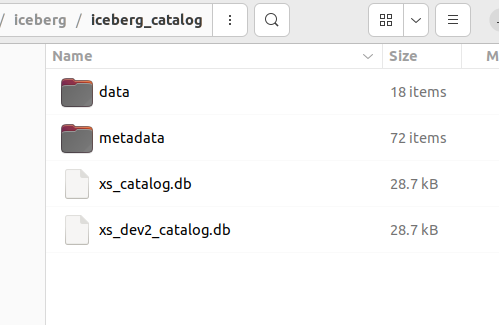

### Query XS  by HUC & additional attributes of interest @ a given HUC from Iceberg Tables

In [21]:
# Scenario I
# User Args
catalog_name = "xs"
huc_num = 10120203

# Load-in table from catalog of interest & observe the first N (e.g. 20) feature columns + schema
tablename = f"huc_{huc_num}"
namespace = "mip"
catalog = load_catalog(name=catalog_name, **{"uri": f"sqlite:///iceberg_catalog/{catalog_name}_catalog.db"})
iceberg_table = catalog.load_table(f"{namespace}.{tablename}").scan().to_arrow()
print(iceberg_table.to_string(preview_cols=30))

pyarrow.Table
river: large_string
reach: large_string
river_reach: large_string
river_station: double
river_reach_rs: large_string
thalweg: double
xs_max_elevation: double
left_reach_length: double
right_reach_length: double
channel_reach_length: double
ras_data: large_string
station_elevation_points: large_string
bank_stations: large_string
number_of_station_elevation_points: int64
number_of_coords: int64
flows: large_string
profile_names: large_string
geometry: large_binary
huc: large_string
model_id: large_string
us_reach_id: large_string
us_network_to_id: large_string
ds_reach_id: large_string
ds_network_to_id: large_string
__index_level_0__: int64
----
river: [["Spearfish Creek","Spearfish Creek","Spearfish Creek","Spearfish Creek","Spearfish Creek",...,"Spearfish Creek","Spearfish Creek","Spearfish Creek","Spearfish Creek","Spearfish Creek"]]
reach: [["Breakout Channel","Breakout Channel","Breakout Channel","Breakout Channel","Breakout Channel",...,"Old US14 Breakou","Old US14 Br

In [22]:
# Scenario II
# User Args
catalog_name = "xs"
huc_num = 17060305

# Load-in table from catalog of interest & observe the first N (e.g. 20) feature columns + schema
tablename = f"huc_{huc_num}"
namespace = "mip"
catalog = load_catalog(name=catalog_name, **{"uri": f"sqlite:///iceberg_catalog/{catalog_name}_catalog.db"})
iceberg_table = catalog.load_table(f"{namespace}.{tablename}").scan().to_arrow()
print(iceberg_table.to_string(preview_cols=30))

pyarrow.Table
river: large_string
reach: large_string
river_reach: large_string
river_station: double
river_reach_rs: large_string
thalweg: double
xs_max_elevation: double
left_reach_length: double
right_reach_length: double
channel_reach_length: double
ras_data: large_string
station_elevation_points: large_string
bank_stations: large_string
number_of_station_elevation_points: int64
number_of_coords: int64
flows: large_string
profile_names: large_string
geometry: large_binary
huc: large_string
model_id: large_string
us_reach_id: large_string
us_network_to_id: large_string
ds_reach_id: large_string
ds_network_to_id: large_string
__index_level_0__: int64
----
river: [["cottonwood_creek","cottonwood_creek","cottonwood_creek","cottonwood_creek","cottonwood_creek",...,"south_fork_clear","south_fork_clear","south_fork_clear","south_fork_clear","south_fork_clear"]]
reach: [["45","45","45","45","45",...,"173","173","173","173","173"]]
river_reach: [["cottonwood_creek,45","cottonwood_creek,45",

In [23]:
# Scenario III
# User Args
catalog_name = "xs"
huc_num = 15040007

# Load-in table from catalog of interest & observe the first N (e.g. 20) feature columns + schema
tablename = f"huc_{huc_num}"
namespace = "mip"
catalog = load_catalog(name=catalog_name, **{"uri": f"sqlite:///iceberg_catalog/{catalog_name}_catalog.db"})
iceberg_table = catalog.load_table(f"{namespace}.{tablename}").scan().to_arrow()
print(iceberg_table.to_string(preview_cols=30))

pyarrow.Table
river: large_string
reach: large_string
river_reach: large_string
river_station: double
river_reach_rs: large_string
thalweg: double
xs_max_elevation: double
left_reach_length: double
right_reach_length: double
channel_reach_length: double
ras_data: large_string
station_elevation_points: large_string
bank_stations: large_string
number_of_station_elevation_points: int64
number_of_coords: int64
flows: large_string
profile_names: large_string
geometry: large_binary
huc: large_string
model_id: large_string
us_reach_id: large_string
us_network_to_id: large_string
ds_reach_id: large_string
ds_network_to_id: large_string
__index_level_0__: int64
----
river: [["1242","1242","1242","1242","1242",...,"1236","1236","1236","1236","1236"]]
reach: [["15","15","15","15","15",...,"61","61","61","61","61"]]
river_reach: [["1242,15","1242,15","1242,15","1242,15","1242,15",...,"1236,61","1236,61","1236,61","1236,61","1236,61"]]
river_station: [[1645.9,1552.446,1458.841,1365.072,1271.617,...

#### Demo:
#### Load Iceberg Catalog & Table of Interest
#### Cross-Check & Verify Parquet Data Has Been Written To Its Associated Iceberg Table Sucessfully

In [24]:
# Query iceberg table for specific features of interest
catalog.load_table(f"{namespace}.{tablename}").scan(
    selected_fields=("huc", "river", "model_id", "us_reach_id", "ds_reach_id")
).to_arrow()

pyarrow.Table
river: large_string
huc: large_string
model_id: large_string
us_reach_id: large_string
ds_reach_id: large_string
----
river: [["1242","1242","1242","1242","1242",...,"1236","1236","1236","1236","1236"]]
huc: [["15040007","15040007","15040007","15040007","15040007",...,"15040007","15040007","15040007","15040007","15040007"]]
model_id: [["1242_ras","1242_ras","1242_ras","1242_ras","1242_ras",...,"1236_ras","1236_ras","1236_ras","1236_ras","1236_ras"]]
us_reach_id: [["None","None","None","None","None",...,"21294309","None","None","None","None"]]
ds_reach_id: [["None","None","None","None","None",...,"21295551","None","None","None","21294309"]]

### Demo VI:
### Load CRS Mapping

In [25]:
with open(f"{os.getcwd()}/xs_data/crs_map/crs_mapping.pickle", "rb") as handle:
    crs_map = pickle.load(handle)

In [26]:
crs_map

defaultdict(dict,
            {('07130010',
              'sa_1'): {'LitCr': 'ESPG: 3436, NAD83 / Illinois West (ftUS),', 'LaMoRv_us': 'ESPG: 3436, NAD83 / Illinois West (ftUS),', 'SBLaMoRv': 'ESPG: 3436, NAD83 / Illinois West (ftUS),', 'LaHaCk': 'ESPG: 3436, NAD83 / Illinois West (ftUS),', 'BapCr': 'ESPG: 3436, NAD83 / Illinois West (ftUS),', 'RocCk': 'ESPG: 3436, NAD83 / Illinois West (ftUS),'},
             ('07130010',
              'Killjordan'): {'Killjordan Cr': 'ESPG: 3436, NAD83 / Illinois West (ftUS),'},
             ('07130010',
              'sa_6'): {'CedCkTrbA': 'ESPG: 3436, NAD83 / Illinois West (ftUS),', 'LaMoRv': 'ESPG: 3436, NAD83 / Illinois West (ftUS),', 'CedCk': 'ESPG: 3436, NAD83 / Illinois West (ftUS),', 'LaMoRvTrbA': 'ESPG: 3436, NAD83 / Illinois West (ftUS),', 'LaMoRvTrbB': 'ESPG: 3436, NAD83 / Illinois West (ftUS),'},
             ('07130010',
              'sa_7'): {'TowFk': 'ESPG: 3436, NAD83 / Illinois West (ftUS),', 'DroFk': 'ESPG: 3436, NAD83 / Illinois W

__Findings:__

To map each cross-section of a model @ HUC#, there has to be a shared attribute between a model @ HUC#'s cross section w/in its XS layer & the details provided within a model @ HUC#'s conflation json file.
  
- Each conflation json file reveals ...
    -  Per reach, there is a set of cross-sections.
    -  Within each model's cross-section (XS) layers, there are a set of cross-section instances - each instance featuring a unique "thalweg" (aka "min_elevation"), "xs_max_elevation" (aka "max_elevation"), "reach_id" ("reaches"), & "river_station" (aka "xs_id")

- Each model @ HUC#'s XS layer contains a collection of cross-section instancees. Thus, each unique cross-section w/in a given model @ HUC#'s XS layer will need to be mapped in such a way to allow each cross-section to be associated with a feature ID (aka "reach_id" and/or "network_to_id")

- "river_reach_rs" is formatted differently across models' XS layers, however multplie keys referenced in the conflation jsons can be referenced to obtain the "river_reach_rs" from the jsons - as a result, the mapping of IDs to each model's cross-section instance will be based on the info extracted from a model @ HUC#'s conflation.json


##### Next Step: 
##### Per HUC, consolidate each XS by River name (aka "model") & save as a geopandas dataframe (ensure CRS is consistent for each geopandas dataframe; check with QGIS)

1) Consolidate XS by river. For each river, save their consolidate XS rows as a geopandas dataframe per river. Ensure their CRS are same.
Keep their unique inherited CRS. Track HUC

2) Consolidate each "river's" geopandas dataframe by HUC & save them as a geoparquet, store in S3

3) Each geoparquets can then be stored as Apache iceberg tables

4) Store Apache iceberg tables in S3


Collection of geoparquets representing each river at a given HUC

model_id2gpkg_map[

## Demo VII: 
### Querying Ripple Layers by HUC Number

In [27]:
rip_huc2gpkg_map["07130010"].keys()

dict_keys(['processing', 'reaches', 'rating_curves', 'network', 'models', 'metadata', 'rating_curves_no_map'])

In [28]:
rip_huc2gpkg_map["07130010"]["reaches"]

,reach_id,nwm_to_id,geometry
0,13585498,13585296,"MULTILINESTRING ((460724.236 1959986.07, 46074..."
1,13585494,13585228,"MULTILINESTRING ((461234.625 1961261.908, 4612..."
2,13802490,13802570,"MULTILINESTRING ((459790.513 1945209.891, 4597..."
3,13802488,13802490,"MULTILINESTRING ((460693.836 1945689.426, 4606..."
4,13802496,13802488,"MULTILINESTRING ((461815.853 1944975.208, 4617..."
...,...,...,...
454,13802636,13802670,"MULTILINESTRING ((427762.55 1940442.3, 427779...."
455,13802664,13802712,"MULTILINESTRING ((428063.956 1939575.769, 4280..."
456,13802724,13802756,"MULTILINESTRING ((427021.923 1937345.91, 42715..."
457,13802904,13802916,"MULTILINESTRING ((434263.443 1931451.676, 4342..."


In [29]:
rip_huc2gpkg_map["07130010"]["rating_curves"]

,reach_id,us_flow,us_depth,us_wse,ds_depth,ds_wse,boundary_condition
0,13801442,43,2.0,683.1,2.6,680.5,nd
1,13801442,45,2.0,683.1,2.7,680.6,nd
2,13801442,167,2.5,683.6,4.6,682.5,nd
3,13801442,289,2.6,683.7,5.2,683.1,nd
4,13801442,411,3.2,684.3,5.5,683.4,nd
...,...,...,...,...,...,...,...
44959,13803872,23939,25.4,622.1,26.4,622.0,kwse
44960,13803872,25696,25.4,622.1,26.4,622.0,kwse
44961,13803872,27698,25.4,622.1,26.4,622.0,kwse
44962,13803872,29406,25.4,622.1,26.4,622.0,kwse


In [30]:
rip_huc2gpkg_map["07130010"]["network"]

,nwm_to_id,updated_to_id
0,13585228,NaN
1,13585296,NaN
2,13801448,13801448.0
3,13801478,NaN
4,13801448,NaN
...,...,...
454,13802232,13802232.0
455,13803712,NaN
456,13802232,NaN
457,13803712,NaN


In [31]:
rip_huc2gpkg_map["07130010"]["models"]

,collection_id,model_id,model_name,conflate_model_job_id,conflate_model_status
0,mip_07130010,sa_7,sa_7,cec7ec7c-fbfa-48da-87ce-c13632b59f09,succeeded
1,mip_07130010,sa_1,sa_1,2c0cd12a-5042-4265-b98e-8f6540cb6e4e,succeeded
2,mip_07130010,sa_6,sa_6,7d85fe34-8960-42c0-9762-6946317a348a,succeeded
3,mip_07130010,sa_5,sa_5,1335125c-2d64-4c4c-a4f7-28fe1cc0e75b,succeeded
4,mip_07130010,sa_4,sa_4,fc5ed1ef-1b3c-4f5e-84ba-b4a45aae15b0,succeeded
5,mip_07130010,LaMoine,LaMoine,212d132f-a10f-48f2-9256-698fb3535860,succeeded
6,mip_07130010,Killjordan,Killjordan,ee89af84-44ea-40a4-9b4c-eea1be29d270,succeeded


# Write local files to S3 (for dev purposes only)
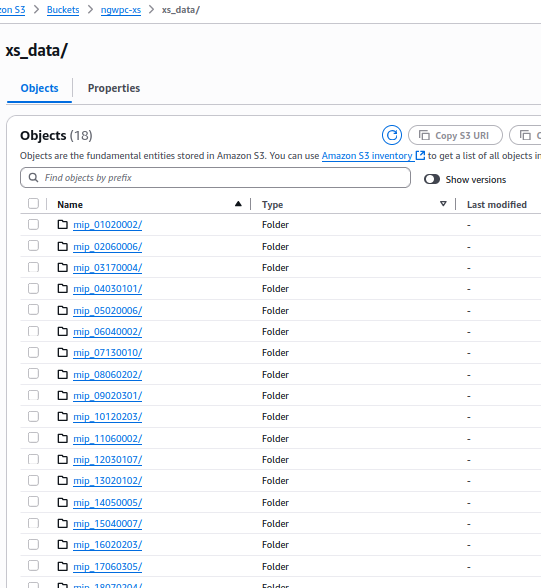
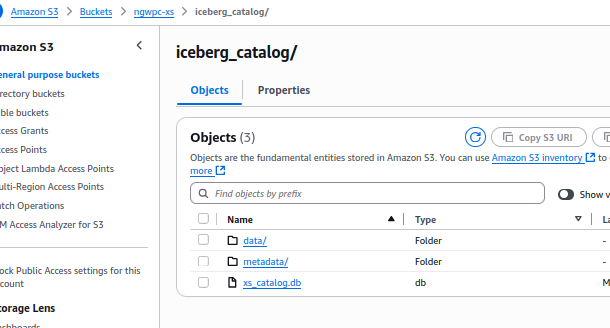

In [32]:
s3_xs_keys2objs = collections.defaultdict()
for folder, subfolders, files in os.walk(f"{os.getcwd()}/xs_data/"):
    for file in files:
        if folder != f"{os.getcwd()}/xs_data/":
            s3_xs_keys2objs[f"{folder.split('/')[-2:][0]}/{folder.split('/')[-2:][1]}/{file}"] = (
                f"{folder}/{file}"
            )

s3_xs_keys2objs

defaultdict(None,
            {'xs_data/mip_07130010/huc_07130010.gpkg': '/home/sylvia.chin/Desktop/iceberg/xs_data/mip_07130010/huc_07130010.gpkg',
             'xs_data/mip_07130010/huc_07130010.parquet': '/home/sylvia.chin/Desktop/iceberg/xs_data/mip_07130010/huc_07130010.parquet',
             'xs_data/mip_09020301/huc_09020301.parquet': '/home/sylvia.chin/Desktop/iceberg/xs_data/mip_09020301/huc_09020301.parquet',
             'xs_data/mip_09020301/huc_09020301.gpkg': '/home/sylvia.chin/Desktop/iceberg/xs_data/mip_09020301/huc_09020301.gpkg',
             'xs_data/mip_06040002/huc_06040002.parquet': '/home/sylvia.chin/Desktop/iceberg/xs_data/mip_06040002/huc_06040002.parquet',
             'xs_data/mip_06040002/huc_06040002.gpkg': '/home/sylvia.chin/Desktop/iceberg/xs_data/mip_06040002/huc_06040002.gpkg',
             'xs_data/mip_03170004/huc_03170004.gpkg': '/home/sylvia.chin/Desktop/iceberg/xs_data/mip_03170004/huc_03170004.gpkg',
             'xs_data/mip_03170004/huc_03170004

In [33]:
s3_xs_iceberg_keys2objs = collections.defaultdict()
for folder, subfolders, files in os.walk(f"{os.getcwd()}/iceberg_catalog/"):
    for file in files:
        if folder != f"{os.getcwd()}/iceberg_catalog/":
            # For all files not the database
            s3_xs_iceberg_keys2objs[f"{folder.split('/')[-2:][0]}/{folder.split('/')[-2:][1]}/{file}"] = (
                f"{folder}/{file}"
            )
        else:
            # For the database.
            s3_xs_iceberg_keys2objs[f"{folder.split('/')[-2:][0]}/{folder.split('/')[-2:][1]}{file}"] = (
                f"{folder}{file}"
            )


s3_xs_iceberg_keys2objs

defaultdict(None,
            {'iceberg_catalog/xs_dev2_catalog.db': '/home/sylvia.chin/Desktop/iceberg/iceberg_catalog/xs_dev2_catalog.db',
             'iceberg_catalog/xs_catalog.db': '/home/sylvia.chin/Desktop/iceberg/iceberg_catalog/xs_catalog.db',
             'iceberg_catalog/metadata/snap-1219395432228756396-0-e0c82612-49a1-4bec-9ffb-0363b2808c90.avro': '/home/sylvia.chin/Desktop/iceberg/iceberg_catalog/metadata/snap-1219395432228756396-0-e0c82612-49a1-4bec-9ffb-0363b2808c90.avro',
             'iceberg_catalog/metadata/79d941be-d64b-420d-8258-ab9a19f60a3c-m0.avro': '/home/sylvia.chin/Desktop/iceberg/iceberg_catalog/metadata/79d941be-d64b-420d-8258-ab9a19f60a3c-m0.avro',
             'iceberg_catalog/metadata/56302b1b-0145-4261-a75f-9fc822513965-m0.avro': '/home/sylvia.chin/Desktop/iceberg/iceberg_catalog/metadata/56302b1b-0145-4261-a75f-9fc822513965-m0.avro',
             'iceberg_catalog/metadata/2b35b175-c393-402f-aefe-7ab21a7f86e3-m0.avro': '/home/sylvia.chin/Desktop/iceber

In [ ]:
# Instantiate bucket of interest.
profile_name = "default"
session = boto3.Session(profile_name=profile_name)
s3 = session.resource("s3")
bucket_name = "ngwpc-xs"

# # Uploading the xs by HUC parquets
# for key, file_dir in s3_xs_keys2objs.items():
#     s3.Bucket(bucket_name).upload_file(file_dir, key)

# Uploading the xs by HUC parquets
# for key, file_dir in s3_xs_iceberg_keys2objs.items():
#     s3.Bucket(bucket_name).upload_file(file_dir, key)

# Cross-Check & Verify:
## Parquet Data Has Been Written To Its Associated Iceberg Table Sucessfully

In [36]:
# Load the Parquet file into a DataFrame
parquet_file_path = f"{os.getcwd()}/xs_data/mip_01020002/huc_01020002.parquet"
parquet_content = pq.read_table(parquet_file_path)
parquet_content

pyarrow.Table
river: string
reach: string
river_reach: string
river_station: double
river_reach_rs: string
thalweg: double
xs_max_elevation: double
left_reach_length: double
right_reach_length: double
channel_reach_length: double
ras_data: string
station_elevation_points: string
bank_stations: string
number_of_station_elevation_points: int64
number_of_coords: int64
flows: string
profile_names: string
geometry: binary
huc: string
model_id: string
us_reach_id: string
us_network_to_id: string
ds_reach_id: string
ds_network_to_id: string
__index_level_0__: int64
----
river: [["Stream0528","Stream0528","Stream0528","Stream0528","Stream0528",...,"Stream0512","Stream0512","Stream0512","Stream0512","Stream0512"]]
reach: [["Reach-1","Reach-1","Reach-1","Reach-1","Reach-1",...,"Reach-1","Reach-1","Reach-1","Reach-1","Reach-1"]]
river_reach: [["Stream0528,Reach-1","Stream0528,Reach-1","Stream0528,Reach-1","Stream0528,Reach-1","Stream0528,Reach-1",...,"Stream0512,Reach-1","Stream0512,Reach-1","Str